In [1]:
import helpers
import numpy as np
import matplotlib.pyplot as plt


# Figure 3

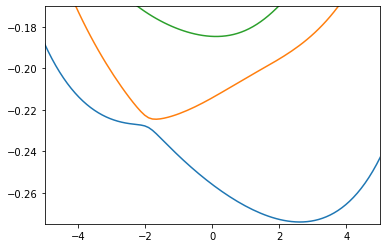

In [3]:
helpers.plot_SM(r_f=5, r_l=4, r_r=3.2, L=19, res=512)

In [25]:
X = np.array([[0, 1], [1, 0]])
I = np.array([[1, 0], [0, 1]])
Y = np.array([[0, -1j], [1j, 0]])

def psm(thing: str):
    kprod = np.array([1])
    pauli_map = {"x": X, "y": Y, "i": I}
    for obj in thing[::-1]:
        term = pauli_map[obj]
        kprod = np.kron(term, kprod)
    kprod = np.real(kprod)
    return np.array(kprod, dtype=np.float64)

In [26]:
from more_itertools import distinct_permutations


def ind_perm(pauli_string):
    string_perm = list(distinct_permutations(pauli_string))
    return ["".join(i) for i in string_perm]


def tridiagonal_decomp(n):
    if n == 1:
        return [(1, "x")]
    new_terms = []
    factor = 1 / (2 ** (n - 1))
    new_sign = 1
    for t in range(int(np.floor(n / 2)) + 1):
        sign = (-1) ** t
        xy_str = ""
        for x in range(n - 2 * t):
            xy_str += "x"
        for y in range(2 * t):
            xy_str += "y"
        for p in ind_perm(xy_str):
            new_terms.append((factor * sign, p))
    for i, val in enumerate(new_terms):
        newval = val[0]
        if val[1][0] == "y":
            newval = val[0] * (-1)
        new_terms[i] = (newval, val[1])

    prev = tridiagonal_decomp(n - 1)
    for i, entry in enumerate(prev):
        prev[i] = (entry[0], "i" + entry[1])
    prev.extend(new_terms)
    return prev


def compute_decomp(decomp):
    summation = decomp[0][0] * psm(decomp[0][1])
    for i in decomp[1:]:
        summation += i[0] * psm(i[1])
    return summation


In [27]:
import qiskit.opflow as op

# I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation
qiskit_map = {"i": op.I, "x": op.X, "y": op.Y}


def qiskit_decomp(n):
    decomp = tridiagonal_decomp(n)

    def map_to_op(entry):
        op_comp = qiskit_map[entry[1][0]]
        for i in entry[1][1:]:
            op_comp = op_comp ^ qiskit_map[i]
        return entry[0] * op_comp

    pauli_op = map_to_op(decomp[0])
    for entry in decomp[1:]:
        pauli_op += map_to_op(entry)
    return pauli_op

In [29]:
import pennylane as qml

qml_map = {"i": None, "x": qml.PauliX, "y": qml.PauliY}


def penny_decomp(n):
    decomp = tridiagonal_decomp(n)

    def map_to_op(entry):
        op_comp = None
        for ind, i in enumerate(entry[1]):
            if i == "i":
                continue
            if op_comp is None:
                op_comp = qml_map[i](ind)
                continue
            op_comp = op_comp @ qml_map[i](ind)
        return op_comp

    coeff = [decomp[0][0]]
    pauli_op = [map_to_op(decomp[0])]
    for entry in decomp[1:]:
        coeff.append(entry[0])
        pauli_op.append(map_to_op(entry))
    return pauli_op, coeff

In [ ]:
normal = []
sizes = []
comm_lf = []
comm_rlf = []
comm_Qlf = []
comm_Qrlf = []

for i in range(2, 11):
    terms, coeff = penny_decomp(i)
    sizes.append(i)
    normal.append(len(terms))
    comm_Qlf.append(
        len(
            qml.pauli.grouping.group_observables(
                terms, grouping_type="qwc", method="lf"
            )
        )
    )
    comm_Qrlf.append(
        len(qml.grouping.group_observables(terms, grouping_type="qwc", method="rlf"))
    )
    comm_lf.append(
        len(
            qml.pauli.grouping.group_observables(
                terms, grouping_type="commuting", method="lf"
            )
        )
    )
    comm_rlf.append(
        len(qml.grouping.group_observables(terms, grouping_type="commuting", method="rlf"))
    )


In [34]:
import seaborn as sns
import pandas as pd
sns.set_context(
    "talk",
    rc={
        "text.usetex": True,
        "font.size": 18,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        "legend.loc": "lower left",
        "legend.frameon": False,
        "font.family": "serif",
        "font.serif": "Times New Roman",
    },
)
df = pd.DataFrame(np.array([sizes,normal,comm_Qlf,comm_rlf]).T,columns=['Dimension','None', 'Qubit-wise commuting', 'Word-wise commuting'])

# Figure S7

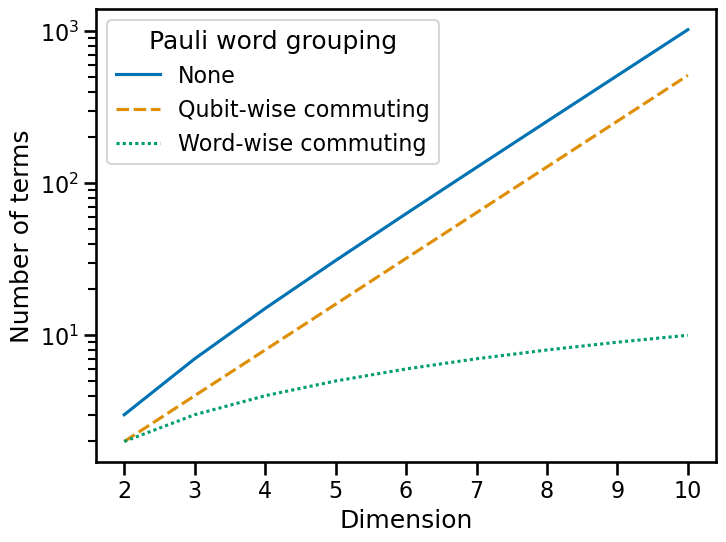

In [36]:
dfplot = df.melt(id_vars='Dimension',var_name='Pauli word grouping',value_name='Number of terms')
fig, ax = plt.subplots(figsize=((8, 6)))

sns.lineplot(data=dfplot,x='Dimension',y="Number of terms",hue='Pauli word grouping',style='Pauli word grouping',ax=ax,palette='colorblind')
plt.yscale('log')
